In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os
import math

In [109]:
dataframes = dict()

for root, dirs, files in os.walk("./data"):
    for file in files:
        if ".csv" in file:
            current_file_path = os.path.join(root, file).replace("\\", "/")
            dataframes[file] = pd.read_csv(current_file_path, sep=';', decimal=',')
    break  # stop at first recursion level: only ./data

# for name,df in dataframes.items():
    # df.info()
    # fig,ax = plt.subplots()
    # ax.plot(df.iloc[])

In [110]:
def linear_damped_oscillator(t, amplitude, gamma, omega_zero, phase):
    return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)

def viscous_damped_oscillator(t, amplitude, alpha, omega_zero, phase):
    return (1 / (1 + amplitude * alpha * t)) * np.cos(omega_zero * t + phase)

def calc_lin_reg(x: list, y: list, x_errs: list, y_errs: list, m_test: float):
    # y = Ax + B
    N = len(x)

    for i in range(N):
        y_errs[i] = math.sqrt(y_errs[i] ** 2 + m_test**2 * x_errs[i] ** 2)

    sum_x2 = 0
    sum_x = 0
    sum_y = 0
    sum_xy = 0
    sum_sigma_y2 = 0

    for i in range(N):
        sum_x += x[i] / y_errs[i] ** 2
        sum_x2 += x[i] ** 2 / y_errs[i] ** 2
        sum_y += y[i] / y_errs[i] ** 2
        sum_xy += x[i] * y[i] / y_errs[i] ** 2
        sum_sigma_y2 += 1 / (y_errs[i] ** 2)

    delta = sum_sigma_y2 * sum_x2 - sum_x**2
    A = (1 / delta) * (sum_sigma_y2 * sum_xy - sum_x * sum_y)
    B = (1 / delta) * (sum_x2 * sum_y - sum_x * sum_xy)
    sA = math.sqrt((1 / delta) * sum_x2)
    sB = math.sqrt((1 / delta) * sum_sigma_y2)

    sigma_y = []
    for i in range(len(y_errs)):
        sigma_y.append(math.sqrt(y_errs[i] ** 2 + (m_test**2) * (x_errs[i] ** 2)))

    return (A, B, sA, sB, sigma_y)


def calc_chi_sqr(observed, expected, sigma_y, deg_of_freedom: int):
    chi2i = np.divide(np.square(observed - expected), np.square(sigma_y))
    chi2 = np.sum(chi2i)
    chi2r = chi2 / deg_of_freedom
    return (chi2i, chi2, chi2r)


In [111]:
"""
for name,df in filter(lambda e: "Oscillazioni" in e[0], dataframes.items()):
    df.dropna(inplace=True)
    fig, axs = plt.subplots(2)


    plot_data = {
        "X": [
            np.linspace(0, len(df.iloc[:,0]), len(df.iloc[:,0])),
            np.linspace(0, len(df.iloc[:,1]), len(df.iloc[:,1]))
        ],
        "Y": [
            df.iloc[:,0],
            df.iloc[:,1]
        ],
    }
    plot_data["linear_fit_args"] = [
        curve_fit(linear_damped_oscillator, plot_data["X"][0], plot_data["Y"][0])[0],
        curve_fit(linear_damped_oscillator, plot_data["X"][1], plot_data["Y"][1])[0]
    ],
    plot_data["viscous_fit_args"] = [
        curve_fit(viscous_damped_oscillator, plot_data["X"][0], plot_data["Y"][0])[0],
        curve_fit(viscous_damped_oscillator, plot_data["X"][1], plot_data["Y"][1])[0]
    ],
    plot_data["linear_fit_Y"] = [
        [linear_damped_oscillator(t, *(plot_data["linear_fit_args"][0])) for t in plot_data["X"][0]],
        [linear_damped_oscillator(t, *(plot_data["linear_fit_args"][1])) for t in plot_data["X"][1]]
    ]
    plot_data["viscous_fit_Y"] = [
        [viscous_damped_oscillator(t, *(plot_data["viscous_fit_args"][0])) for t in plot_data["X"][0]],
        [viscous_damped_oscillator(t, *(plot_data["viscous_fit_args"][1])) for t in plot_data["X"][1]]
    ]


    for i in range(2):
        axs[i].scatter(plot_data["X"][i], plot_data["Y"][i], marker='.', s=0.3, alpha=0.5, c='tab:red')
        axs[i].plot(plot_data["X"][i], plot_data["linear_fit_Y"][i], linewidth=0.5)
        axs[i].plot(plot_data["X"][i], plot_data["viscous_fit_Y"][i], linewidth=0.5)

        # axs[1].scatter(X2, Y2, marker='.', s=0.3, alpha=0.5, c='tab:red')
        # axs[1].plot(X2, linear_fit_Y2, linewidth=0.5)
        # axs[1].plot(X2, viscous_fit_Y2, linewidth=0.5)
"""

'\nfor name,df in filter(lambda e: "Oscillazioni" in e[0], dataframes.items()):\n    df.dropna(inplace=True)\n    fig, axs = plt.subplots(2)\n\n\n    plot_data = {\n        "X": [\n            np.linspace(0, len(df.iloc[:,0]), len(df.iloc[:,0])),\n            np.linspace(0, len(df.iloc[:,1]), len(df.iloc[:,1]))\n        ],\n        "Y": [\n            df.iloc[:,0],\n            df.iloc[:,1]\n        ],\n    }\n    plot_data["linear_fit_args"] = [\n        curve_fit(linear_damped_oscillator, plot_data["X"][0], plot_data["Y"][0])[0],\n        curve_fit(linear_damped_oscillator, plot_data["X"][1], plot_data["Y"][1])[0]\n    ],\n    plot_data["viscous_fit_args"] = [\n        curve_fit(viscous_damped_oscillator, plot_data["X"][0], plot_data["Y"][0])[0],\n        curve_fit(viscous_damped_oscillator, plot_data["X"][1], plot_data["Y"][1])[0]\n    ],\n    plot_data["linear_fit_Y"] = [\n        [linear_damped_oscillator(t, *(plot_data["linear_fit_args"][0])) for t in plot_data["X"][0]],\n       

/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarning: overflow encountered in exp
  return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)
/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarning: overflow encountered in multiply
  return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)
/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarning: overflow encountered in exp
  return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)
/tmp/ipykernel_1100/3520418707.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  linear_fit_args, _ = curve_fit(linear_damped_oscillator, X, Y)
/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarning: overflow encountered in multiply
  return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)
/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarning: overflow encountered in exp
  return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)
/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarn

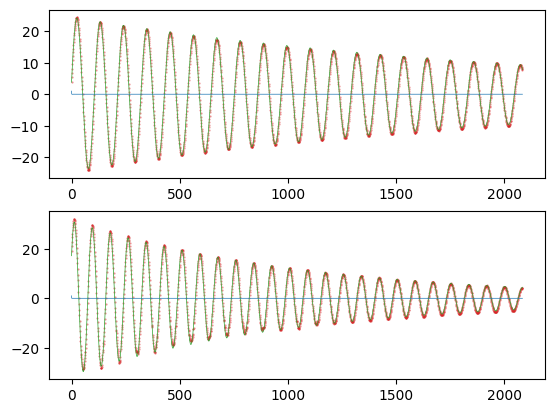

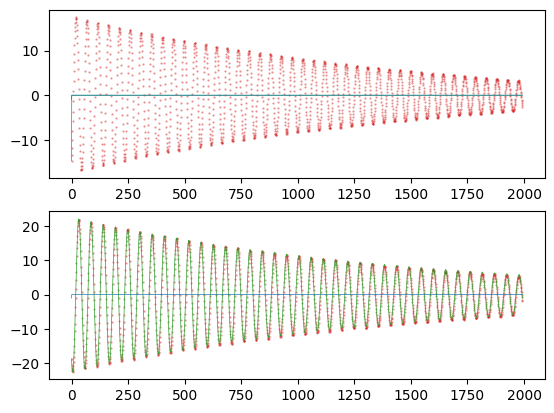

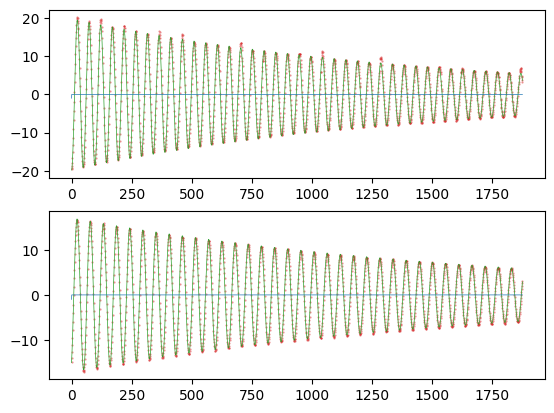

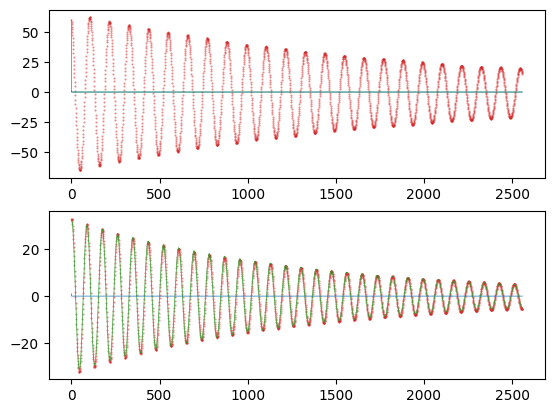

In [112]:
### C2 = 0 ###

for name,df in filter(lambda e: "Oscillazioni" in e[0], dataframes.items()):
    df.dropna(inplace=True)
    fig,ax = plt.subplots(2)
    
    for i in range(2):
        X = np.linspace(0, len(df.iloc[:,i]), len(df.iloc[:,i]))
        Y = df.iloc[:,i]
        
        linear_fit_args, _ = curve_fit(linear_damped_oscillator, X, Y)
        viscous_fit_args, _ = curve_fit(viscous_damped_oscillator, X, Y)
        
        ax[i].scatter(X, Y, s=0.3, alpha=0.5, c='tab:red')
        ax[i].plot(X, linear_damped_oscillator(X, *linear_fit_args), linewidth=0.5, c='tab:green')
        ax[i].plot(X, viscous_damped_oscillator(X, *viscous_fit_args), linewidth=0.5, c='tab:blue')